In [2]:
import os
import numpy as np
from liver_data_check import imageLoader
# import tensorflow as tf  # tensorflow==2.2.0
# import segmentation_models_3D as sm
# from tensorflow import keras
import keras
from matplotlib import pyplot as plt
import glob
import random

In [ ]:
import tensorflow as tf

tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10904688269136667879
xla_global_id: -1
]


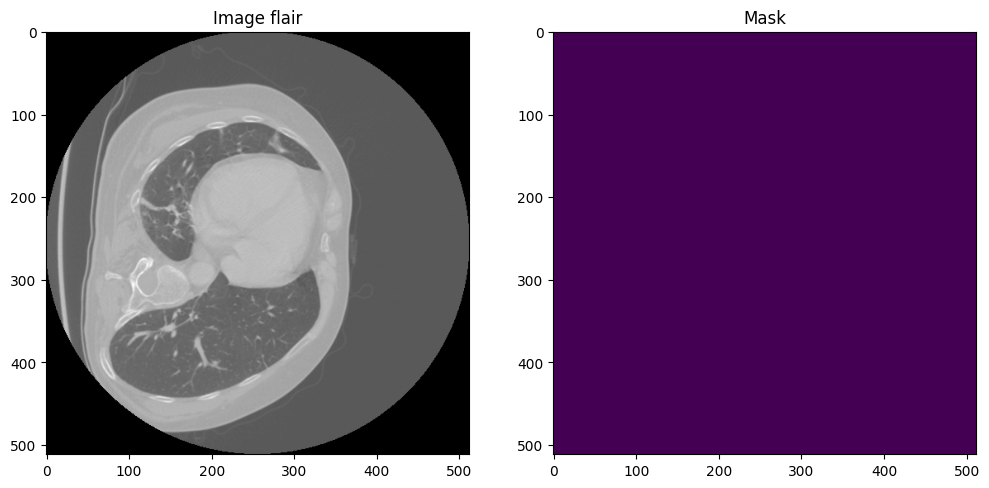

In [3]:
####################################################
train_img_dir = r'E:\Task03_Liver\ML_Liver\splitted\\train\images\\'
train_mask_dir = r"E:\Task03_Liver\ML_Liver\splitted\train\masks\\"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(122)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:

#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob(r"E:\Task03_Liver\ML_Liver\splitted\train\masks\\*.npy"))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    print("val", val, "counts", counts)
    zipped = zip(columns, counts)
    print("zipped ", zipped)
    conts_dict = dict(zipped)
    print("conts_dict ", conts_dict)
    df = df.append(conts_dict, ignore_index=True)

print("df", df)
label_0 = df['0'].sum()
print("label_0 ", label_0)
label_1 = df['1'].sum()
print("label_1 ", label_1)
label_2 = df['1'].sum()
print("label_2 ", label_2)
# label_3 = df['3'].sum()
# print("label_3 ", label_3)
total_labels = label_0 + label_1 + label_2 # + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss

0
val [0 1 2] counts [62903017  4205057      790]
zipped  <zip object at 0x00000240D73BCC08>
conts_dict  {'0': 62903017, '1': 4205057, '2': 790}
1
val [0 1 2] counts [65208312  1876901    23651]
zipped  <zip object at 0x00000240D73C9248>
conts_dict  {'0': 65208312, '1': 1876901, '2': 23651}
2
val [0 1 2] counts [64074931  3031321     2612]
zipped  <zip object at 0x00000240D73B6388>
conts_dict  {'0': 64074931, '1': 3031321, '2': 2612}
3
val [0 1 2] counts [64027170  3080819      875]
zipped  <zip object at 0x00000240D73C9208>
conts_dict  {'0': 64027170, '1': 3080819, '2': 875}
4
val [0 1 2] counts [63570927  3164815   373122]
zipped  <zip object at 0x00000240D73C9888>
conts_dict  {'0': 63570927, '1': 3164815, '2': 373122}
5
val [0 1 2] counts [63488454  3582734    37676]
zipped  <zip object at 0x00000240D73BCD48>
conts_dict  {'0': 63488454, '1': 3582734, '2': 37676}
df             0          1         2   3
0  62903017.0  4205057.0     790.0 NaN
1  65208312.0  1876901.0   23651.0 NaN
2 

In [4]:
##############################################################
#Define the image generators for training and validation

train_img_dir = r"E:\Task03_Liver\ML_Liver\splitted\train\images\\"
train_mask_dir = r"E:\Task03_Liver\ML_Liver\splitted\train\masks\\"

val_img_dir = r"E:\Task03_Liver\ML_Liver\splitted\val\images\\"
val_mask_dir = r"E:\Task03_Liver\ML_Liver\splitted\val\masks\\"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

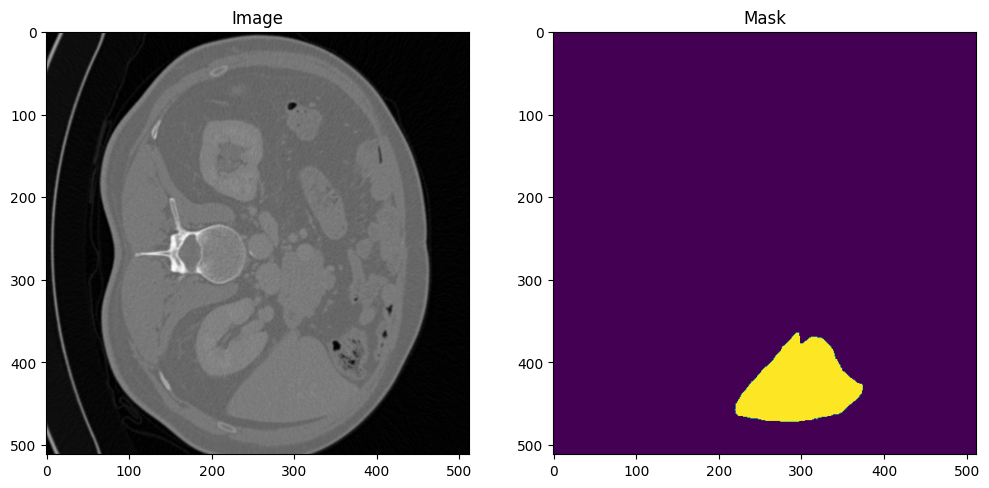

In [5]:
########################################################################
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image')
plt.subplot(122)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



In [17]:
###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2 = 0.25,0.25,0.25
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
# from keras.optimizer_v2.adam import Adam as Adam
LR = 0.0001
optim = keras.optimizers.Adam(LR)

AttributeError: module 'keras.optimizers' has no attribute 'Adam'

In [14]:
import loss_function as lf
import categorical_loss_function as clf

dice_loss = lf.dice_loss_3d
# focal_loss = clf.categorical_focal_loss
# total_loss = dice_loss + focal_loss

metrics = ['accuracy']

LR = 0.0001
optim = keras.optimizers.Adam(LR)

AttributeError: module 'keras.optimizers' has no attribute 'Adam'

In [12]:
#######################################################################
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


from  u_net_3d import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=512,
                          IMG_WIDTH=512,
                          IMG_DEPTH=256,
                          IMG_CHANNELS=1,
                          num_classes=3)

model.compile(optimizer = optim, loss=dice_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('liver_3d.hdf5')

ImportError: cannot import name 'Adam' from 'keras.optimizers' (c:\users\piotr\pycharmprojects\liver_cancer\env_python37\lib\site-packages\keras\optimizers.py)

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18119014076184002851
xla_global_id: -1
]


In [ ]:
##################################################################


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
#################################################
from keras.models import load_model

#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


OSError: No file or directory found at saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5

In [10]:
#################################################

#For predictions you do not need to compile the model, so ...
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())



OSError: No file or directory found at saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5

In [ ]:

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 82

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################